# Sleep Prediction
Here we try to use environmental parameters in addition to mood and activity characteristics to see if we are able to predict sleep quality.

## Features
In this analysis, we are going to consider the following features:
1. **Acitivity**: The main metrics for activity that we will use are:
    * Daily Steps
    * Intensity Levels
2. **Mood**: We have five metrics for mood:
    * Content
    * Lonely
    * Sadness
    * Stress
    * Energy Level 
3. **IEQ**: There are many measurements of IEQ that we consider:
    * CO$_2$
    * CO
    * PM$_{2.5}$
    * NO$_2$
    * TVOCs
    * Temperature
    * Relative Humidity
    
## Targets
The targets will be all metrics related to sleep quality:
1. **Self-Report**: There are four metrics for self-report sleep quality reported via EMA:
    * TST
    * SOL
    * NAW
    * Restfulness
2. **Fitbit-Measured**: There are also four metrics of sleep quality that we can use from Fitbit:
    * TST
    * SE
    * REM Percentage
    * Light Percentage
    * Deep Percentage

In [4]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [5]:
# general
import os
import sys
sys.path.append('../')
# user-defined functions
from src.visualization import visualize
# basic data science
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
# timeseries
from datetime import datetime, timedelta
# plottings
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Data Import](#data-import)
3. [Target Encoding](#encoding)
4. [Feature Engineering](#feature_engineering)
5. [Prediction](#prediction)
    1. [Fitbit Sleep Targets](#fitbit-sleep-prediction)
        1. TST
        2. SOL
        3. WASO
        4. REM:nREM
        5. SE
    2. [Self-Report Sleep Targets](#self-report-sleep-prediction)
        1. TST
        2. SOL
        3. NAW
        4. Restfulness
6. [Prediction with Encoded Features](#prediction_encoded)
7. [Final Analysis](#final_analysis)

<a id="data-import"></a>

# Data Import
For this analysis we want to only consider nights when we have _all_ the available data. These are also the nights that we have confirmed participants are home according to GPS traces. 

## Feature: IEQ
We start with IEQ data beacuse from previous analysis, this dataset has already been curated to include the relevant nights. However, there are quite a few columns that are not necessary for this analysis that have to be removed.

In [6]:
ieq_raw = pd.read_csv("../data/processed/beacon_by_night-ux_s20.csv",parse_dates=["start_time","end_time",],infer_datetime_format=True)
ieq_raw = ieq_raw[(ieq_raw["home"] == 1) | (ieq_raw["increasing_co2"] > 0.5)]
ieq_raw.drop(["home","increasing_co2","ema","pm1_number","pm2p5_number","pm10_number","pm1_mass","pm10_mass","no2"],axis="columns",inplace=True)
ieq_raw = ieq_raw.groupby(["beacon","beiwe","redcap","start_time","end_time"]).median()
ieq_raw = ieq_raw.add_suffix("_median")
ieq_raw.reset_index(inplace=True)
ieq = ieq_raw.copy()
ieq.head()

,beacon,beiwe,redcap,start_time,end_time,tvoc_median,lux_median,co_median,co2_median,pm2p5_mass_median,temperature_c_median,rh_median,fitbit_median
0,1,kyj367pi,10,2020-06-10 23:05:00,2020-06-11 09:14:00,69.472597,0.0,4.809835,607.609765,16.515731,17.359939,39.483333,24
1,1,kyj367pi,10,2020-06-11 23:12:00,2020-06-12 09:14:00,210.569596,0.0,4.275798,630.040491,34.128077,16.455691,40.436667,24
2,1,kyj367pi,10,2020-06-17 22:55:00,2020-06-18 08:51:00,310.293674,0.0,3.570167,616.201568,20.605142,16.615442,45.706667,24
3,1,kyj367pi,10,2020-06-18 22:13:00,2020-06-19 08:42:00,300.139737,0.0,2.922652,598.332358,20.834074,18.173762,46.830000,24
4,1,kyj367pi,10,2020-06-20 23:06:00,2020-06-21 07:43:00,307.701799,0.0,3.140130,585.162549,15.928621,17.359939,47.862500,24


<div class="alert alert-block alert-danger">
 
Since we have so many `nan` values and even the values we have are not very exciting, we leave out the `no2` measurements.
    
</div>

## Feature: Activity
Activity data are essentially untouched from the raw format

In [7]:
activity_raw = pd.read_csv("../data/processed/fitbit-daily-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
activity = activity_raw[["timestamp","beiwe","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"]]
activity.rename({"timestamp":"date"},axis="columns",inplace=True)
activity.head()

,date,beiwe,steps,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes
0,2020-05-13,hfttkth7,9207,1241,70,118,11
1,2020-05-14,hfttkth7,15207,614,263,134,23
2,2020-05-15,hfttkth7,14556,577,205,57,108
3,2020-05-16,hfttkth7,18453,760,176,24,151
4,2020-05-17,hfttkth7,15425,605,207,50,131


## Feature: Mood
We only want to consider mood data from the latest survey prior to the participant going to sleep so we only important the evening EMAs.

In [8]:
mood = pd.read_csv("../data/processed/beiwe-evening_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
mood["date"] = pd.to_datetime(mood["timestamp"].dt.date)
mood.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,redcap,beacon,date
0,2020-05-13 19:00:23,awa8uces,1.0,1.0,1.0,3.0,2.0,28,26.0,2020-05-13
1,2020-05-13 19:21:32,lkkjddam,0.0,2.0,3.0,1.0,0.0,12,21.0,2020-05-13
2,2020-05-13 19:30:38,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,NaN,2020-05-13
3,2020-05-13 20:07:04,xxvnhauv,1.0,3.0,1.0,2.0,0.0,21,22.0,2020-05-13
4,2020-05-13 20:25:07,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,24.0,2020-05-13


## Target: Self-Report Sleep Quality (SRSQ)
The self-reported sleep quality comes from the morning EMAs.

In [9]:
srsq_raw = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
srsq_raw["date"] = pd.to_datetime(srsq_raw["timestamp"].dt.date)
srsq = srsq_raw[["timestamp","date","beiwe","redcap","beacon","tst","sol","naw","restful"]]
srsq.rename({"date":"end_date"},axis="columns",inplace=True)
srsq.head()

,timestamp,end_date,beiwe,redcap,beacon,tst,sol,naw,restful
0,2020-05-13 09:10:00,2020-05-13,qh34m4r9,68.0,19.0,8.0,20.0,2.0,3.0
1,2020-05-13 09:15:00,2020-05-13,awa8uces,28.0,26.0,2.0,10.0,3.0,1.0
2,2020-05-13 09:42:00,2020-05-13,xxvnhauv,21.0,22.0,6.0,30.0,3.0,1.0
3,2020-05-13 09:43:00,2020-05-13,rvhdl2la,29.0,NaN,5.3,5.0,2.0,2.0
4,2020-05-13 10:11:00,2020-05-13,q5y11ytm,48.0,NaN,2.0,10.0,0.0,0.0


## Target: Fitbit Sleep Quality (FBSQ)
Fitbit sleep summary data is imported below.

In [10]:
fbsq_raw = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date"],infer_datetime_format=True)
fbsq = fbsq_raw[["start_time","end_time","start_date","end_date","beiwe","redcap","beacon","tst_fb","efficiency","rem_percent","light_percent","deep_percent"]]
fbsq.rename({"tst_fb":"tst","efficiency":"se"},axis="columns",inplace=True)
fbsq.head()

,start_time,end_time,start_date,end_date,beiwe,redcap,beacon,tst,se,rem_percent,light_percent,deep_percent
0,2020-05-14 00:27:00,2020-05-14 07:13:00,2020-05-14,2020-05-14,hfttkth7,NaN,NaN,6.316667,93.349754,0.216359,0.562005,0.221636
1,2020-05-14 23:53:30,2020-05-15 08:06:30,2020-05-14,2020-05-15,hfttkth7,NaN,NaN,6.533333,79.513185,0.119898,0.637755,0.242347
2,2020-05-15 23:28:00,2020-05-16 04:57:00,2020-05-15,2020-05-16,hfttkth7,NaN,NaN,4.783333,87.234043,0.174216,0.662021,0.163763
3,2020-05-17 02:01:30,2020-05-17 09:28:30,2020-05-17,2020-05-17,hfttkth7,NaN,NaN,6.716667,90.156600,0.205955,0.600496,0.193548
4,2020-05-18 00:24:00,2020-05-18 07:20:00,2020-05-18,2020-05-18,hfttkth7,NaN,NaN,5.850000,84.375000,0.250712,0.475783,0.273504


## Target: Combined Sleep Quality (CSQ)
The sleep quality dataset has already been created from a previous analysis so we simply just have to import it.

I don't think we will be using this dataset, but we might as well keep it here.

In [11]:
sleep_quality = pd.read_csv("../data/processed/beiwe_fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date","date"],infer_datetime_format=True)
csq = sleep_quality[["start_time","end_time","start_date","end_date","date","beiwe","redcap","beacon","tst_ema","sol_ema","naw_ema","restful_ema","tst_fb","efficiency","rem_percent","nrem_percent"]]
csq.head() # Combined Sleep Quality (csq)

,start_time,end_time,start_date,end_date,date,beiwe,redcap,beacon,tst_ema,sol_ema,naw_ema,restful_ema,tst_fb,efficiency,rem_percent,nrem_percent
0,2020-05-14 01:06:00,2020-05-14 11:39:30,2020-05-14,2020-05-14,2020-05-14,15tejjtw,45.0,NaN,9.0,30.0,5.0,2.0,8.766667,83.096367,0.231939,0.768061
1,2020-05-16 02:19:00,2020-05-16 10:00:30,2020-05-16,2020-05-16,2020-05-16,15tejjtw,45.0,NaN,9.0,15.0,2.0,2.0,6.600000,85.900217,0.123737,0.876263
2,2020-05-17 00:27:00,2020-05-17 10:28:00,2020-05-17,2020-05-17,2020-05-17,15tejjtw,45.0,NaN,9.0,30.0,1.0,2.0,8.850000,88.352745,0.254237,0.745763
3,2020-05-18 01:37:00,2020-05-18 10:59:30,2020-05-18,2020-05-18,2020-05-18,15tejjtw,45.0,NaN,9.0,25.0,2.0,1.0,7.966667,85.053381,0.207113,0.792887
4,2020-05-21 23:59:30,2020-05-22 09:27:30,2020-05-21,2020-05-22,2020-05-22,15tejjtw,45.0,NaN,9.0,20.0,2.0,2.0,8.316667,87.852113,0.264529,0.735471


<a id="encoding" ></a>

# Target Encoding
We will encode all the target sleep quality variables as binary where 0 represents poor/negative outcomes and 1 are good/positive outcomes.

In [12]:
def plot_distribution(df, variable,**kwargs):
    """plots distribution of values"""
    fig, ax = plt.subplots(figsize=(12,4))
    # density plot
    sns.kdeplot(x=variable,cut=0,data=df,zorder=2,
                linewidth=3,color="black",ax=ax)
    # x-axis
    plt.xticks(fontsize=14)
    ax.set_xlabel(variable.upper(),fontsize=16)
    if "xlim" in kwargs.keys():
        ax.set_xlim(kwargs["xlim"])
    else:
        ax.set_xlim([0,max(df[variable])])
    # cumulative
    ax2 = ax.twinx()
    sns.kdeplot(x=variable,cut=0,data=df,cumulative=True,zorder=1,
                linewidth=2,color="firebrick",ax=ax2)
    # y-axis
    ax.set_yticks([])
    ax.set_ylabel("")
    ax2.set_ylabel("")
    ax2.set_ylim([0,1])
    ax2.set_yticks([0,0.25,0.5,0.75,1])
    plt.yticks(fontsize=14)
    # remainder
    for loc in ["left","top"]:
        ax.spines[loc].set_visible(False)
        ax2.spines[loc].set_visible(False)
    plt.show()
    plt.close()

## SE
Based on a discussion with Dr. Schnyer, he suggested this scale (with some minor tweaks in language from me):

| SE | Rating | Value |
| --- | --- | --- |
| >90% | Excellent | 3 |
| 85% - 90% | Good | 2 |
| 80% - 85% | Typical | 1 |
| <80% | Poor | 0 |



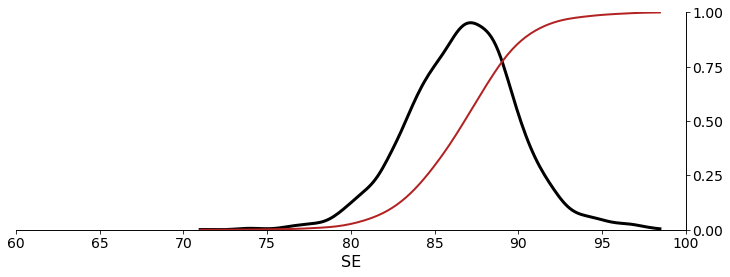

In [13]:
plot_distribution(fbsq,"se",xlim=[60,100])

Here, we just say the SE is good (1) when above 85%, otherwise it is bad (0).

In [14]:
def encode_se(value):
    """returns encoded value for se"""
    if value >= 85:
        return 1
    else:
        return 0

## TST
Based on a "traditional" recommendations, we can lump `tst` into three categories:

| TST | Rating | Value |
| --- | --- | --- |
| >9 h | High | 0 |
| 7-9 h | Typical | 1 |
| <7 h | Low | 0 |

In [15]:
def encode_tst(value):
    """returns score of tsts"""
    if value > 9:
        return 0
    elif value >= 7:
        return 1
    else:
        return 0

## REM
Ideally you should be spending between 20% and 25% of your night in REM sleep.

In [16]:
def encode_rem(value):
    """returns score of REM percent"""
    if value >= 0.2 and value <= 0.25:
        return 1
    else:
        return 0

## Light Sleep
Light Sleep should be a maximum of about 60% but we also don't want too little. 

In [17]:
def encode_light(value):
    """returns score of light percent"""
    if value >= 0.4 and value <= 0.6:
        return 1
    else:
        return 0

## Deep Sleep
Deep sleep should encompass about 12% to 23% of your night.

In [18]:
def encode_deep(value):
    """returns score of deep percent"""
    if value >= 0.12 and value <= 0.23:
        return 1
    else:
        return 0

## SOL
The National Sleep Foundation says 30 minutes or less is a marker for good sleep quality. However, looking at the distribution of values, perhaps we should alter that threshold since many of the participants fall asleep faster than that.

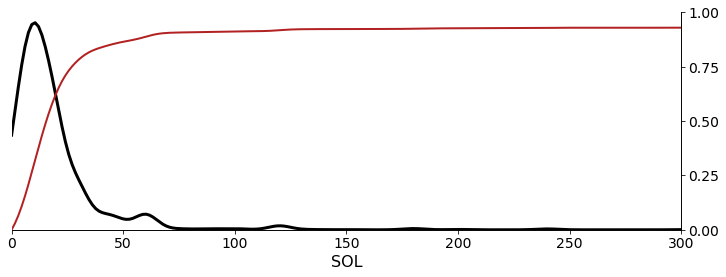

In [19]:
plot_distribution(srsq,"sol")

In [20]:
def encode_sol(value):
    """returns score of sol"""
    if value < 15:
        return 1
    else:
        return 0

## NAW
We group NAW into a good and bad category based on [Ohayon et al., 2017](https://www.sciencedirect.com/science/article/pii/S2352721816301309?casa_token=56p9duOGsL4AAAAA:tmPWLtzq0Z9zGGq-w0qWBXJT-VEDeoZ0dOwL06G-BwbWMHA3uT_KBjxd08HPyFZWNqIpm_0m).

| NAW | Rating | Value |
| --- | --- | --- |
| 0 or 1 | Good | 1 |
| >1 | Bad | 0 |

In [21]:
def encode_naw(value):
    """returns score of naw"""
    if value < 2:
        return 1
    else:
        return 0

## Restfulness
Restfulness is one of the five metrics that is rated on a 0 to 3 Likert scale. So we can create a more generic function here for later use.

In [22]:
def encode_likert(value):
    """returns score for a 0-3 Likert measurement"""
    if value > 1:
        return 1
    else:
        return 0

## Encoding Sleep Quality

### Self-Report Sleep
We start with self-report metrics of sleep quality.

In [23]:
for sm, f in zip(["tst","sol","naw","restful"], [encode_tst,encode_sol,encode_naw,encode_likert]):
    srsq[f"{sm}_binary"] = srsq.apply(lambda x: f(x[sm]), axis="columns")
    
srsq.head()

,timestamp,end_date,beiwe,redcap,beacon,tst,sol,naw,restful,tst_binary,sol_binary,naw_binary,restful_binary
0,2020-05-13 09:10:00,2020-05-13,qh34m4r9,68.0,19.0,8.0,20.0,2.0,3.0,1,0,0,1
1,2020-05-13 09:15:00,2020-05-13,awa8uces,28.0,26.0,2.0,10.0,3.0,1.0,0,1,0,0
2,2020-05-13 09:42:00,2020-05-13,xxvnhauv,21.0,22.0,6.0,30.0,3.0,1.0,0,0,0,0
3,2020-05-13 09:43:00,2020-05-13,rvhdl2la,29.0,NaN,5.3,5.0,2.0,2.0,0,1,0,1
4,2020-05-13 10:11:00,2020-05-13,q5y11ytm,48.0,NaN,2.0,10.0,0.0,0.0,0,1,1,0


### Fitbit Sleep
And now Fitbit-measured sleep quality.

In [24]:
for sm, f in zip(["tst","se","rem_percent","light_percent","deep_percent"], [encode_tst,encode_se,encode_rem,encode_light,encode_deep]):
    fbsq[f"{sm}_binary"] = fbsq.apply(lambda x: f(x[sm]), axis="columns")
    
fbsq.head()

,start_time,end_time,start_date,end_date,beiwe,redcap,beacon,tst,se,rem_percent,light_percent,deep_percent,tst_binary,se_binary,rem_percent_binary,light_percent_binary,deep_percent_binary
0,2020-05-14 00:27:00,2020-05-14 07:13:00,2020-05-14,2020-05-14,hfttkth7,NaN,NaN,6.316667,93.349754,0.216359,0.562005,0.221636,0,1,1,1,1
1,2020-05-14 23:53:30,2020-05-15 08:06:30,2020-05-14,2020-05-15,hfttkth7,NaN,NaN,6.533333,79.513185,0.119898,0.637755,0.242347,0,0,0,0,0
2,2020-05-15 23:28:00,2020-05-16 04:57:00,2020-05-15,2020-05-16,hfttkth7,NaN,NaN,4.783333,87.234043,0.174216,0.662021,0.163763,0,1,0,0,1
3,2020-05-17 02:01:30,2020-05-17 09:28:30,2020-05-17,2020-05-17,hfttkth7,NaN,NaN,6.716667,90.156600,0.205955,0.600496,0.193548,0,1,1,0,1
4,2020-05-18 00:24:00,2020-05-18 07:20:00,2020-05-18,2020-05-18,hfttkth7,NaN,NaN,5.850000,84.375000,0.250712,0.475783,0.273504,0,0,0,1,0


<a id="feature_engineering" ></a>

# Feature Engineering
In the following cells, we encode the various features to binary outcomes and combine the features into one dataset. 

## Encoding
We encode each of the features into a binary outcome.

### Activity

#### Activity Level
Encoding the activity levels can be accomplished by looking at recommendations from the American College of Sports Medicine. ACSM states that adults should do:
* Moderate Intensity: 150 - 300 minutes per week, or
* Vigorous: 75 - 150 minutes per week, or
* Combination

Fitbit divides activity level into multiple categories that are not exactly the same label as what the ACSM states. While the cutoff points are not very clear, they are most likely:
* Sedentary: MET < 1
* Light: MET < 3
* Fairly: MET < 6 (ACSM Moderate)
* Very: > 6 (ACSM Vigorous)

We look on a per-day basis so the cutoffs discussed above can be altered:
* Moderate: 21 - 43 minutes per day
* Vigorous: 11 - 21 minutes per day

We will start with what seems the most straightforward separation: getting enough moderate and vigorous activity per day. Based on the guidelines, one needs twice as many moderate minutes as vigorous minutes of activity. In order to address the "combination" category, we can multiply the number of vigorous minutes by 2 and add this value to the moderately active minutes which will allow us to compare this value to the moderately active minutes threshold. 

In [25]:
def encode_activity_level(row, moderate_threshold=30):
    """returns score of activity level"""
    if row["fairly_active_minutes"] + row["very_active_minutes"]*2 > moderate_threshold:
        return 1
    else:
        return 0

#### Number of Steps
An attainable goal that all adults should strive for is about 10,000 steps a day

In [26]:
def econde_steps(value):
    if value > 10000:
        return 1
    else:
        return 0

In [27]:
activity["active_binary"] = activity.apply(lambda row: encode_activity_level(row), axis="columns")
activity["steps_binary"] = activity.apply(lambda x: econde_steps(x["steps"]), axis="columns")
activity.head()

,date,beiwe,steps,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,active_binary,steps_binary
0,2020-05-13,hfttkth7,9207,1241,70,118,11,1,0
1,2020-05-14,hfttkth7,15207,614,263,134,23,1,1
2,2020-05-15,hfttkth7,14556,577,205,57,108,1,1
3,2020-05-16,hfttkth7,18453,760,176,24,151,1,1
4,2020-05-17,hfttkth7,15425,605,207,50,131,1,1


### Mood
Each of the mood scores (except for `energy`) are on the same Likert scale as `restful` so we can just use that function to encode the mood scores. For `energy`, there are only two negative responses so we will consider the `Neutral` response as a positive score which allows us to use the same function.

In [28]:
for variable in ["content","stress","lonely","sad","energy"]:
    mood[f"{variable}_binary"] = mood.apply(lambda x: encode_likert(x[variable]), axis="columns")
    
mood.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,redcap,beacon,date,content_binary,stress_binary,lonely_binary,sad_binary,energy_binary
0,2020-05-13 19:00:23,awa8uces,1.0,1.0,1.0,3.0,2.0,28,26.0,2020-05-13,0,0,0,1,1
1,2020-05-13 19:21:32,lkkjddam,0.0,2.0,3.0,1.0,0.0,12,21.0,2020-05-13,0,1,1,0,0
2,2020-05-13 19:30:38,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,NaN,2020-05-13,1,0,0,0,0
3,2020-05-13 20:07:04,xxvnhauv,1.0,3.0,1.0,2.0,0.0,21,22.0,2020-05-13,0,1,0,1,0
4,2020-05-13 20:25:07,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,24.0,2020-05-13,1,0,1,0,1


### IEQ
For the IEQ data, we want to determine whether the concentrations are low or high depending on the participant's own environment. So the process will involve looking at each of the IEQ measurements from each participant, finding the mean of those nights, and then determining 1 (low) or 0 (high).

In [29]:
def encode_ieq(value, threshold):
    """Scores the IEQ parameter"""
    if value <= threshold:
        return 1
    else:
        return 0

In [30]:
ieq_bi = pd.DataFrame()
stat="median"
for pt in ieq["beiwe"].unique():
    ieq_pt = ieq[ieq["beiwe"] == pt]
    for pollutant in ["co2", "co","tvoc","pm2p5_mass","temperature_c","rh"]:#"no2"
        mean_night = np.nanmean(ieq_pt[f"{pollutant}_{stat}"])
        ieq_pt[f"{pollutant}_{stat}_binary"] = ieq_pt.apply(lambda x: encode_ieq(x[f"{pollutant}_{stat}"],mean_night), axis="columns")
        
    ieq_bi = ieq_bi.append(ieq_pt)
    
ieq_bi.head()

,beacon,beiwe,redcap,start_time,end_time,tvoc_median,lux_median,co_median,co2_median,pm2p5_mass_median,temperature_c_median,rh_median,fitbit_median,co2_median_binary,co_median_binary,tvoc_median_binary,pm2p5_mass_median_binary,temperature_c_median_binary,rh_median_binary
0,1,kyj367pi,10,2020-06-10 23:05:00,2020-06-11 09:14:00,69.472597,0.0,4.809835,607.609765,16.515731,17.359939,39.483333,24,1,0,1,1,1,1
1,1,kyj367pi,10,2020-06-11 23:12:00,2020-06-12 09:14:00,210.569596,0.0,4.275798,630.040491,34.128077,16.455691,40.436667,24,1,0,1,0,1,1
2,1,kyj367pi,10,2020-06-17 22:55:00,2020-06-18 08:51:00,310.293674,0.0,3.570167,616.201568,20.605142,16.615442,45.706667,24,1,1,0,1,1,1
3,1,kyj367pi,10,2020-06-18 22:13:00,2020-06-19 08:42:00,300.139737,0.0,2.922652,598.332358,20.834074,18.173762,46.830000,24,1,1,0,1,0,1
4,1,kyj367pi,10,2020-06-20 23:06:00,2020-06-21 07:43:00,307.701799,0.0,3.140130,585.162549,15.928621,17.359939,47.862500,24,1,1,0,1,1,0


## Correcting EMA Timestamp
The EMAs are tricky because they can be submitted at any time. So we need to make sure that the `date` column we merge along corresponds to the correct end date of the Fitbit sleep event. 

In [31]:
def correct_ema_date(ema, fbs, threshold=3, verbose=True):
    """adds new column corresponding to the day when the participant woke"""
    ema_with_dates = pd.DataFrame()
    for pt in ema["beiwe"].unique():
        end_dates = []
        if verbose:
            print("Participant:", pt)
        # getting data per participant
        ema_pt = ema[ema["beiwe"] == pt]
        try:
            fb_pt = fbs[fbs["beiwe"] == pt]
        except KeyError:
            if verbose:
                print("\tNo Fitbit Data")
            continue
        # looping through submission times
        for submission_time in ema_pt["timestamp"]:
            end_dates.append(np.nan) # appending to keep same length
            fb_since = fb_pt[fb_pt["start_time"] > submission_time] # Fitbit sleep data since the EMA was submitted
            try:
                dt = fb_since["start_time"].iloc[0] - submission_time # get time difference between when the EMA was submitted and the Fitbit started logging data
            except IndexError:
                if verbose:
                    print("\tNo Fitbit Data after EMA submission of", submission_time.date())
                continue
            if dt < timedelta(hours=threshold): # if the EMA was submitted a certain time before the sleep event, add the actual date
                if submission_time.hour > 12:
                    end_dates[-1] = submission_time.date() + timedelta(days=1)
                else:
                    end_dates[-1] = submission_time.date()
                    
        ema_pt["end_date"] = pd.to_datetime(end_dates)
        if verbose:
            print((ema_pt["date"] == ema_pt["end_date"]).value_counts())
            print()
        ema_with_dates = ema_with_dates.append(ema_pt)
        
    return ema_with_dates

We get a new mood dataframe with the `end_date` column which we will merge along.

In [32]:
new_mood = correct_ema_date(mood, fbsq, threshold=5, verbose=False)

## Correcting Activity Date
The activity date corresponds to the day on which the participant was that active. Since all the other dates are relative to when the participant wakes up, we have to add a day to the activity data.

In [33]:
activity["end_date"] = activity["date"] + timedelta(days=1)

## Combining
Now that we have encoded all the target variables, we can combine them in different datasets to get a better sense of the available data for prediction. The common link between all the datasets will be the IEQ dataset since we are aiming to use those variables as a novel approach to prediction.

### IEQ Only
Considering the base case: just IEQ observations.

In [34]:
print("Number of observations:",len(ieq_bi))

Number of observations: 584


### Activity and IEQ

In [35]:
ieq_bi["end_date"] = pd.to_datetime(ieq_bi["end_time"].dt.date)
ieq_and_activity = ieq_bi.merge(right=activity,on=["end_date","beiwe"])
print("Number of observations:",len(ieq_and_activity))

Number of observations: 541


<div class="alert alert-block alert-success">
 
By including activity data, we lose 43 observations from the original target dataset. This percent loss might even be smaller considering we haven't combined the data with the target datasets yet.
    
</div>

### Mood and IEQ

In [36]:
ieq_and_mood = ieq_bi.merge(right=new_mood,on=["end_date","beiwe","redcap","beacon"])
print("Number of observations:",len(ieq_and_mood))

Number of observations: 116


<div class="alert alert-block alert-danger">
 
Unfortunately the mood data is too sparsely represented and _dramatically_ reduces the amount of observations that we have.
    
</div>

### Activity, Mood, and IEQ

In [37]:
features_all = ieq_and_activity.merge(right=new_mood, on=["end_date","beiwe","redcap","beacon"])
print("Number of observations:",len(features_all))

Number of observations: 104


<div class="alert alert-block alert-danger">
 
Now looping in all three feature sets, we see that we only hae 70 observations to work with and this is before merging with the target datasets which would cut down our dataset even more. 
    
</div>

<a id="exploration"></a>

# Data Exploration
Now that we have our features and targets, we can look at the data to get a better sense of what we can do with it.

We have to start by combining the features and targets so that we are looking at the finalized dataset.

In [38]:
# Fitbit
combined_fb = ieq_and_activity.merge(right=fbsq,on=["beiwe","end_date"])
combined_fb_simple = combined_fb[[column for column in combined_fb.columns if column.endswith("binary")]]
# Beiwe
combined_sr = ieq_and_activity.merge(right=srsq,on=["beiwe","end_date"])
combined_sr_simple = combined_sr[[column for column in combined_sr.columns if column.endswith("binary")]]

In [39]:
def plot_summary_count(df,variable):
    """plots the stripplot of a binary variable"""
    figure, ax = plt.subplots(figsize=(4,4))
    # count
    sns.countplot(x=variable,data=df,
                  edgecolor="black",ax=ax)
    # stats
    ax.text(0,len(df),f"Mean: {round(np.nanmean(df[variable]),2)}",va="top",ha="center",fontsize=14)
    # x-axis
    plt.xticks(fontsize=14)
    ax.set_xlabel(variable.split("_")[0].upper(),fontsize=16)
    # y-axis
    plt.yticks(fontsize=14)
    ax.set_ylabel("Count",fontsize=16)
    ax.set_ylim([0,len(df)])
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    plt.show()
    plt.close()

## Summary of Features
We start with the features

## Summary of Targets
For the targets, our main concern is that we are getting equal representation from each of the responses. A lack of observations might lead to poorly performing models.

### Fitbit
Fitbit sleep targets and distribution of responses.

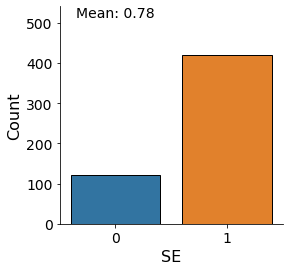

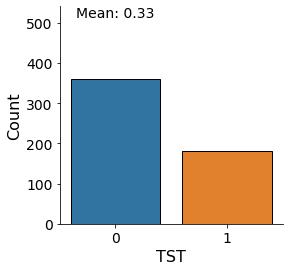

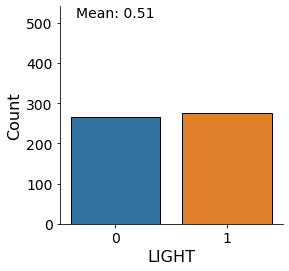

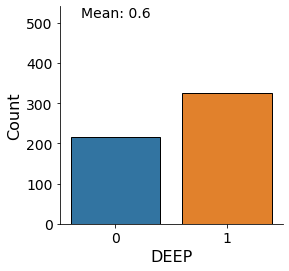

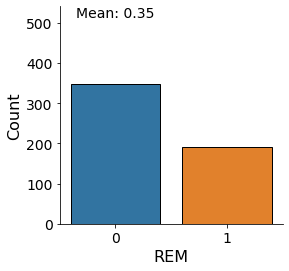

In [40]:
for fb_target in ["se","tst","light_percent","deep_percent","rem_percent"]:
    plot_summary_count(combined_fb_simple,f"{fb_target}_binary")

### Self-Report
And now for the self-report metrics

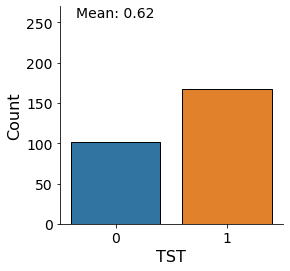

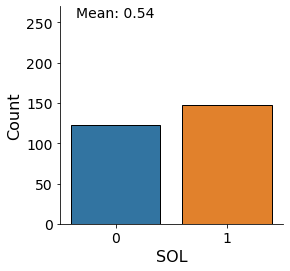

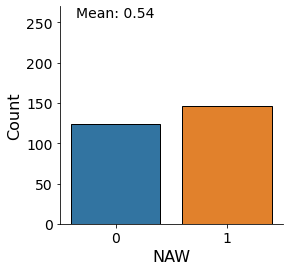

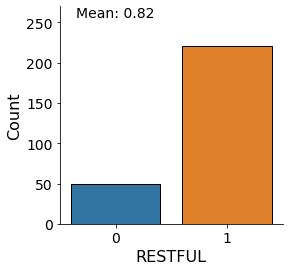

In [41]:
for sr_target in ["tst","sol","naw","restful"]:
    plot_summary_count(combined_sr_simple,f"{sr_target}_binary")

<a id="prediction"></a>

# Prediction
Now that we have sufficiently explored the features, we can begin to try predicting various components of sleep quality. We will try a wide-variety of classifiers to determine which is the most applicable to solving our problem. The classifiers that we use can be seen in the following cell via the `import` statements.

## Linear Regression
We use linear regression as a first step in the analysis.

In [42]:
from sklearn.linear_model import LinearRegression

In [43]:
class linear_model:
    
    def __init__(self):
        pass
    
    def set_x_and_y(self, feature_set, target_set, features=["co2_median","co_median","pm2p5_mass_median","no2_median","temperature_c_median","rh_median","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"], target="tst"):
        """sets the x and y parameters"""
        # for reference
        self.target_label = target
        self.feature_labels = features
        combined = feature_set.merge(right=target_set,on=["beiwe","end_date"])
        combined_simple = combined[[column for column in combined.columns if not column.endswith("binary") and not column.endswith("x") and not column.endswith("y")]]
        combined_simple.dropna(inplace=True)
        # getting x and y
        self.y = combined_simple[[f"{target}"]]
        self.X = combined_simple[[column for column in combined.columns if column.endswith("median") or column.endswith("minutes") or column == "steps"]]
        self.X = self.X[features]

    def set_model(self):
        """runs a linear leasts-squares regression model"""
        self.model = LinearRegression(normalize=True).fit(self.X,self.y)
        temp = pd.DataFrame(data={"feature":self.feature_labels,"coefficient":self.model.coef_[0]})
        self.coefficients = temp.sort_values("coefficient")
    
    def run(self, feature_set, target_set, features=["co2_median","co_median","pm2p5_mass_median","no2_median","temperature_c_median","rh_median","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"], target="tst"):
        """runs the linear model"""
        self.set_x_and_y(feature_set, target_set, features, target)
        self.set_model()
        print(self)
        
    def get_r2(self):
        """gets r2"""
        return round(self.model.score(self.X, self.y),3)
    
    def get_coefs(self):
        """gets coefficients of the model"""
        return self.coefficients
    
    def __str__(self):
        """output"""
        print("Linear Model")
        try:
            print("Observations:", len(self.X))
            print("Score:", self.get_r2())
            print("Coefficients:")
            for feature, c in zip(self.get_coefs().iloc[:,0], self.get_coefs().iloc[:,1]):
                print(f"\t{feature}:\t{round(c,4)}")
        except AttributeError:
            print("No Model found")
            
        return ""

### Aggregate
All the participants' data considered

In [44]:
lm = linear_model()
lm.run(ieq_and_activity, fbsq, features=["co2_median","co_median","pm2p5_mass_median","temperature_c_median","rh_median","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"])

Linear Model
Observations: 427
Score: 0.089
Coefficients:
	temperature_c_median:	-0.0482
	lightly_active_minutes:	-0.0024
	sedentary_minutes:	-0.0005
	co2_median:	-0.0
	steps:	-0.0
	fairly_active_minutes:	0.0008
	very_active_minutes:	0.0081
	co_median:	0.0085
	rh_median:	0.0113
	pm2p5_mass_median:	0.0124



## Classification

In [45]:
# Logistic Regressions
from sklearn.linear_model import LogisticRegression
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Support Vector
from sklearn.svm import SVC
# Multi-Layer Perceptron
from sklearn.neural_network import MLPClassifier
# ADAboost
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
# Bagging
from sklearn.ensemble import BaggingClassifier

To automate the prediction/evaluation process, we have created the class below that utilizes the following steps:
1. Feature and Target Data Split: The feature and target datasets are fed into the program, cross-referenced, and then split.
2. Train/Test Split: Data are split into a training and a testing split

In [46]:
from sklearn import metrics, tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, GroupKFold, LeaveOneGroupOut, StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, f1_score, precision_recall_curve, plot_precision_recall_curve, accuracy_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance


class ieq_and_sq_prediction:
    
    def __init__(self):
        """initializes the model parameters"""
        self.classifier_model_params_complete = {
            "logistic_regression": {
                "model":LogisticRegression(random_state=42,max_iter=500),
                "params": {
                    "fit_intercept":[True,False],
                    "solver":["lbfgs","liblinear"],
                }
            },
            "random_forest": {
                "model":RandomForestClassifier(random_state=42),
                "params": {
                    "n_estimators":[10,50,100],
                    "max_depth":[1,2,3,4,5],
                    "min_samples_split":[2,4],
                    "min_samples_leaf":[1,2],
                }
            },
            "bernoulli_naive_bayes": {
                "model":BernoulliNB(binarize=None),
                "params": {
                    "alpha":[0,0.5,1],
                }
            },
            "k-nearest_neighbor": {
                "model":KNeighborsClassifier(),
                "params": {
                    "n_neighbors":[3,5,7],
                    "weights":["uniform","distance"],
                    "p":[1,2],
                }
            },
            "support_vector": {
                "model":SVC(random_state=42),
                "params": {
                    "kernel":["linear","poly","sigmoid","rbf"],
                }
            }
        }
        self.classifier_model_params_test = {
            "gradientboost":{
                "model": GradientBoostingClassifier(random_state=42),
                "params": {
                    "n_estimators":[10,50,100],
                    "max_depth":[1,2,3,4,5],
                    "min_samples_split":[2,4],
                    "min_samples_leaf":[1,2],
                }
            }
        }
        self.classifier_model_params = {
            "logistic_regression": {
                "model":LogisticRegression(random_state=42,max_iter=500),
                "params": {
                    "fit_intercept":[True,False],
                    "solver":["lbfgs","liblinear"],
                }
            },
            "gradientboost":{
                "model": GradientBoostingClassifier(random_state=42),
                "params": {
                    "n_estimators":[10,50,100],
                    "max_depth":[1,2,3,4,5],
                    "min_samples_split":[2,4],
                    "min_samples_leaf":[1,2],
                }
            },
            "k-nearest_neighbor": {
                "model":KNeighborsClassifier(),
                "params": {
                    "n_neighbors":[3,5,7],
                    "weights":["uniform","distance"],
                    "metric":["euclidean","manhattan","minkowski","jaccard","matching"],
                    "p":[1,2],
                }
            }
        }
        #decision_tree = DecisionTreeClassifier(max_depth=2,min_samples_leaf=2,min_samples_split=2)
        self.tuned_models = {"logistic_regression":LogisticRegression(random_state=42,fit_intercept=True,solver="lbfgs",max_iter=500),
                             "knn":KNeighborsClassifier(n_neighbors=7,metric="euclidean",weights="uniform",p=1),
                             "random_forest":GradientBoostingClassifier(random_state=42,n_estimators=10,max_depth=1,min_samples_leaf=1,min_samples_split=2)}
    
    #"random_forest":AdaBoostClassifier(decision_tree,random_state=42,n_estimators=10)
    def get_features_and_targets(self, feature_set, target_set, target="tst"):
        """gets feature set and target set for the same observations"""
        self.target_label = target
        print(f"Getting Features and Target ({target})...")
        # selecting only important target
        target_set_reduced = target_set[["beiwe","end_date",f"{target}_binary"]]
        # combining datasets to get overlapping observations
        combined = feature_set.merge(right=target_set_reduced,on=["beiwe","end_date"])
        combined = combined.merge(right=combined["beiwe"].value_counts().rename("count"),left_on="beiwe",right_index=True,how="left")
        combined = combined[combined["count"] > 1]
        combined_simple = combined[[column for column in combined.columns if column.endswith("binary") or column in ["count","beiwe"]]]
        # splitting into features and targets
        targets = combined_simple[[f"{target}_binary"]]
        features = combined_simple.drop([f"{target}_binary","beiwe"],axis="columns")
        self.groups = combined_simple["beiwe"]
        self.counts = features["count"]
        self.features = features.drop(["count"],axis="columns")
        self.targets = targets
        
    def split_data(self, test_size=0.33):
        """splits data into training and testing"""
        print("Splitting Data...")
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.targets, test_size=test_size, random_state=10, stratify=self.counts)
        #self.X_train.drop("count",axis="columns",inplace=True)
        #self.X_test.drop("count",axis="columns",inplace=True)
        
    def set_test_and_train(self,X_train,X_test,y_train,y_test):
        """sets the training data - use for specialized train_test_split"""
        for dataset in [X_train,X_test,y_train,y_test]:
            try: 
                dataset.drop(["count"],axis="columns",inplace=True)
            except KeyError:
                pass
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
    def set_weights(self,**kwargs):
        """sets the weights based on the y_train data"""
        if "y_train" in kwargs.keys():
            self.y_train = kwargs["y_train"]
        try:
            low_n = self.y_train.value_counts().sort_index().iloc[0]
            high_n = self.y_train.value_counts().sort_index().iloc[1]
            self.weights = [len(self.y_train) / (2 * low_n) if val == 0 else len(self.y_train) / (2 * high_n) for val in self.y_train[f"{target}_binary"]]
        except Exception as e:
            print(e)
            self.weights = None # defaults to None so the fit() function will work
        
    def optimize_models(self):
        """runs gridsearch cv"""
        print("Testing Classifiers...")
        try:
            scores = []
            params = self.classifier_model_params
            self.set_weights()
            for model_name, mp in params.items():
                s = datetime.now()
                print(f"\t{model_name.replace('_',' ').title()}")
                clf = GridSearchCV(mp["model"],mp["params"],cv=5,return_train_score=False)
                clf.fit(self.X_train,self.y_train,self.weights)
                scores.append({
                    "model":model_name,
                    "best_score":clf.best_score_,
                    "best_params":clf.best_params_
                })
                print("\t\tElapsed Time:\t", datetime.now() - s)
                print(f"\t\tBest Score:\t{clf.best_score_}\n\t\tBest Params:\t{clf.best_params_}")

            results = pd.DataFrame(scores,columns=["model","best_score","best_params"])
            # getting and saving best model
            results.sort_values(["best_score"],ascending=False,inplace=True)
            self.results = results
            best = results.iloc[0,:]
            # outputting results
            print(f"\tBest Scoring Model:")
            print(f"\t\tModel:\t{best[0].replace('_',' ').title()}\n\t\tScore:\t{round(best[1],3)}\n\t\tParams:\t{best[2]}")
        except AttributeError:
            print("Training data do not exist - run split_data()")
        
    def train_model(self, model):
        """trains the specified model"""
        print("Training...")
        self.model = model # necessary if running functions separately
        try:
            self.set_weights()
            self.X_train = self.X_train
            self.X_test = self.X_test
            try:
                self.model.fit(self.X_train,self.y_train,self.weights)
            except TypeError:
                self.model.fit(self.X_train,self.y_train)
        except AttributeError:
            print("Training data do not exist - run split_data()")
    
    def predict(self):
        """gets the predicted results based on the model provided for the given target"""
        print("Predicting...")
        try:
            self.predictions = self.model.predict(self.X_test)
            
            self.score = metrics.precision_score(self.y_test,self.predictions,average="weighted")

            scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring='precision_weighted')
            print("\tCross Validation Scores:")
            for scr in scores:
                print(f"\t\t{round(scr,3)}")
            print(f"\tAverage:\t{round(scores.mean(),3)}")
            print(f"\tModel Score: {round(self.score,3)}")
        except AttributeError:
            print("Missing attributes - make sure you split the data and trained the model")
        
    def plot_confusion_matrix(self, save=False, target_label=""):
        """plots confusion matrix"""
        print("Evaluating...")
        # get confusion matrix
        cm = metrics.confusion_matrix(self.y_test,self.predictions)
        cm_df = pd.DataFrame(cm)
        # plot confusion matrix as heatmap
        fig, ax = plt.subplots(figsize=(5,4))
        sns.heatmap(cm_df,annot=True,cmap="Blues",ax=ax)
        ax.set_xlabel("Predicted Label",fontsize=16)
        ax.set_ylabel("True Label",fontsize=16)
        if save:
            plt.savefig(f"../../../Documents/sbac_2021/project/figures/confusion_matrix-{target_label}.pdf")
        plt.show()
        plt.close()
        
    def set_feature_importance(self,plot=False):
        """gets feature importance from classifier models"""
        try:
            # getting importance df
            importance = pd.DataFrame(data={"feature":[value.split('_')[0] for value in self.features.columns],"importance":self.model.feature_importances_})
            importance.sort_values("importance",inplace=True)
            self.feature_importance = importance
            if plot:
                # getting color map
                my_cmap = plt.get_cmap("Blues")
                rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
                # plotting
                fig, ax = plt.subplots(figsize=(6,4))
                ax.barh(importance["feature"],importance["importance"],color=my_cmap(rescale(importance["importance"])),edgecolor="black",tick_label=[visualize.get_label(label) for label in importance["feature"]])
                # x-axis
                plt.xticks(fontsize=12)
                ax.set_xlabel("Importance",fontsize=14)
                # y-axis
                plt.yticks(fontsize=12)
                ax.set_ylabel("Feature",fontsize=14)
                # remainder
                for loc in ["top","right"]:
                    ax.spines[loc].set_visible(False)
                plt.show()
                plt.close()
        except AttributeError as e:
            print(e)
            
    def get_permutation_importance(self,scoring="accuracy"):
        """"""
        self.set_weights()
        res_dict = {}
        for model_name, mp in self.tuned_models.items():
            try:
                clf = mp.fit(self.X_train,self.y_train,self.weights)
            except TypeError:
                clf = mp.fit(self.X_train,self.y_train)
            res = permutation_importance(clf, self.X_test, self.y_test, n_repeats=10,random_state=42,scoring=scoring)
            vals = [0 if m < 0 else m for m in res.importances_mean]
            res_dict[model_name] = vals
        return res_dict
            
    def run(self, feature_set, target_set, target="tst", test_size=0.33):
        """runs the class: split, test, predict, evaluate"""
        self.get_features_and_targets(feature_set, target_set, target=target)
        self.split_data(test_size=test_size)
        # gridsearch on models
        self.optimize_models()
        # saves the best model, trains on the best model, predicts with the model, and plots the confusion matrix
        for model_number in range(len(self.results)):
            print(self.results.iloc[model_number,0].replace("_"," ").upper())
            self.model = self.classifier_model_params[self.results.iloc[model_number,:]["model"]]["model"].set_params(**self.results.iloc[model_number,:]["best_params"])
            self.train_model(self.model)
            self.predict()
            self.plot_confusion_matrix()
            self.set_feature_importance(plot=True)
            
    def get_cv(self,validation="gkf",splits=5):
        """gets cv object"""
        if validation == "gkf":
            return GroupKFold(n_splits=splits)
        elif validation == "logo":
            return LeaveOneGroupOut()
        elif validation == "skf":
            return StratifiedKFold(n_splits=splits)
        else:
            return KFold(n_splits=splits)        
            
    def plot_roc_auc(self,validation="gkf",splits=5,save=False,**kwargs):
        """Trains the tuned models and cross-validates"""
        cv = self.get_cv(validation,splits)
            
        fig, axes = plt.subplots(1,len(self.tuned_models.keys()),figsize=(6*len(self.tuned_models.keys()),6),sharey=True)
        for (name, model), ax in zip(self.tuned_models.items(),axes.flat):
            tprs = []
            aucs = []
            f1s = []
            mean_fpr = np.linspace(0, 1, 100)
            for i, (train, test) in enumerate(cv.split(self.features, self.targets, groups=self.groups)):
                clf = model.fit(self.features.iloc[train],self.targets.iloc[train])
                scores = clf.predict(self.features.iloc[test])
                try:
                    fpr, tpr, thresholds = roc_curve(self.targets.iloc[test], clf.predict_proba(self.features.iloc[test])[:, 1])
                    auc_score = roc_auc_score(self.targets.iloc[test], clf.predict_proba(self.features.iloc[test])[:, 1])
                    f1 = f1_score(self.targets.iloc[test], scores)
                    if validation != "logo":
                        ax.plot(fpr,tpr,lw=1,alpha=0.5,label=f"Fold {i+1}")
                    interp_tpr = np.interp(mean_fpr, fpr, tpr)
                    interp_tpr[0] = 0.0
                    tprs.append(interp_tpr)
                    aucs.append(auc_score)
                    f1s.append(f1)
                except ValueError as e:
                    print(e)
                
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color='black',label=f'Mean ROC',lw=3, alpha=.8)#\n')
            ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
            ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
            if name not in ["knn"]:
                ax.set_title(f'{name.replace("_"," ").title()}',fontsize=16)
            else:
                ax.set_title(f'KNN',fontsize=16)
            plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)
            ax.legend(frameon=True,loc="lower right",bbox_to_anchor=(1.2,0),fontsize=12,)
            # annotations
            ax.text(0.0,0.9,f"AUC = {round(mean_auc,2)} $\pm$ {round(std_auc,2)}",fontsize=14)
        if save:
            plt.savefig(f"../reports/conferences/BuildSys_2021/{self.target_label}-{validation}cv-roc_curve.pdf")
            
        if "annote" in kwargs.keys():
            axes[0].text(0.05,1,kwargs["annote"],va="bottom",ha="left",fontsize=24)
        fig.add_subplot(111, frame_on=False)
        plt.tick_params(labelcolor="none", bottom=False, left=False)
        plt.xlabel("False Positive Rate",fontsize=15)
        plt.ylabel("True Positive Rate",fontsize=15)
        plt.show()
        plt.close()
        
    def find_accuracy_threshold(self):
        """"""
        fig, axes = plt.subplots(1,len(self.tuned_models.keys()),figsize=(6*len(self.tuned_models.keys()),6),sharey=True)
        for (name, model), ax in zip(self.tuned_models.items(),axes.flat):
            clf = model.fit(self.X_train,self.y_train)
            y_pred_pos = clf.predict_proba(self.X_test)[:,1]
            thresholds = []
            accs = []
            for threshold in np.linspace(0,1,100):
                thresholds.append(threshold)
                y_pred_class = y_pred_pos > threshold
                acc = accuracy_score(self.y_test, y_pred_class)
                accs.append(acc)
            ax.plot(thresholds,accs,color="black",lw=2)
            ix = np.argmax(accs)
            ax.set_title(thresholds[ix])
        plt.show()
        plt.close()

    def plot_pr_auc(self,cv="gkf",splits=5,save=False):
        """plots the precision-recall curve"""
        cv = self.get_cv(cv,splits)
        
        fig, axes = plt.subplots(1,len(self.tuned_models.keys()),figsize=(6*len(self.tuned_models.keys()),6),sharey=True)
        final_accuracies = []
        final_fscores = []
        final_thresholds = []
        final_aucs = []
        final_naives = []
        final_feature_importances = {new_list: [] for new_list in self.tuned_models.keys()}
        for (name, model), ax in zip(self.tuned_models.items(),axes.flat):
            precisions = []
            thresholds = []
            accuracies = []
            mean_recall = np.linspace(0, 1, 100)
            feature_importances = []
            fscores_balanced = []
            for i, (train, test) in enumerate(cv.split(self.features, self.targets, groups=self.groups)):
                clf = model.fit(self.features.iloc[train],self.targets.iloc[train])
                precision, recall, threshold = precision_recall_curve(self.targets.iloc[test], clf.predict_proba(self.features.iloc[test])[:, 1])
                if cv != "logo":
                    ax.plot(recall,precision,lw=1,alpha=0.5,label=f"Fold {i+1}")
                    
                precisions.append(np.interp(mean_recall, np.sort(recall), precision))
                thresholds.append(np.interp(mean_recall, np.sort(recall), np.append(threshold,[1])))
                fscores_balanced.append(f1_score(self.targets.iloc[test],clf.predict(self.features.iloc[test])))
                accuracies.append(accuracy_score(self.targets.iloc[test],clf.predict(self.features.iloc[test])))
                if name == "random_forest":
                    feature_importances.append(clf.feature_importances_)
                elif name == "logistic_regression":
                    feature_importances.append(clf.coef_[0])
                else:
                    feature_importances.append(np.zeros(len(self.features.columns)))
            
            final_feature_importances[name] = pd.DataFrame(data=feature_importances).mean(axis=0).values
            mean_precision = np.mean(precisions, axis=0)
            mean_threshold = np.mean(thresholds, axis=0)
            mean_auc = auc(mean_recall,mean_precision)
            fscore = (2 * mean_precision * mean_recall[::-1]) / (mean_precision + mean_recall[::-1])
            # locate the index of the largest f score
            ix = np.argmax(fscore)
            score = round(sum(self.targets.iloc[:,0])/len(self.targets),2)
            print(f'Model={name}\n\tAccuracy = {round(np.mean(accuracies),2)}\n\tF-Score (adjusted) = {round(fscore[ix],2)} ({round(mean_threshold[ix],2)})\n\tPR_AUC = {round(mean_auc,2)}\n\tNaive Score = {score if score > 0.5 else 1-score}')
            
            for val, li in zip([round(np.mean(accuracies),2),round(fscore[ix],2),round(mean_threshold[ix],2),round(mean_auc,2),score if score > 0.5 else 1-score],[final_accuracies,final_fscores,final_thresholds,final_aucs,final_naives]):
                li.append(val)
            ax.plot(mean_recall[::-1], mean_precision, color='black',lw=3, alpha=.8)#,label=f'Mean ROC\nAUC = {round(mean_auc,2)} $\pm$ {round(std_auc,2)}'
            ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
            # remainder
            if name not in ["knn"]:
                ax.set_title(f'{name.replace("_"," ").title()}',fontsize=16)
            else:
                ax.set_title(f'KNN',fontsize=16)
            plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
            plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)
            ax.legend(frameon=False,loc="lower right",bbox_to_anchor=(1.2,0),fontsize=12,)
        if save:
            plt.savefig(f"../reports/conferences/BuildSys_2021/{self.target_label}-{validation}cv-roc_curve.pdf")
            
        fig.add_subplot(111, frame_on=False)
        plt.tick_params(labelcolor="none", bottom=False, left=False)
        plt.xlabel("Recall",fontsize=15)
        plt.ylabel("Precision",fontsize=15)
        plt.show()
        plt.close()
            
        return pd.DataFrame(data={"accuracy":final_accuracies,"f1":final_fscores,"threshold":final_thresholds,"pr_auc":final_aucs,"naive":final_naives}), final_feature_importances
    
    def get_performance(self,cv="gkf",splits=5,save=False):
        """gest performance metrics for the model and prediction"""
        cv = self.get_cv(cv,splits)
        # defining result dicts
        model_res = {"target":[],"model":[],"accuracy":[],"accuracy_naive":[],"f1":[],"f1_naive":[]}
        pred_res = {"target":[],"model":[],"accuracy":[],"accuracy_naive":[],"f1":[],"f1_naive":[]}
        final_feature_importances = {new_list: [] for new_list in self.tuned_models.keys()}
        # looping through models
        for name, model in self.tuned_models.items():
            # pre-allocating empty metric lists
            precisions = {"train":[],"test":[]}
            thresholds = {"train":[],"test":[]}
            accuracies = {"train":[],"test":[]}
            mean_recall = np.linspace(0, 1, 100)
            feature_importances = []
            # looping through cv folds
            for i, (train, test) in enumerate(cv.split(self.features, self.targets, groups=self.groups)):
                # training model
                clf = model.fit(self.features.iloc[train],self.targets.iloc[train])
                # metrics for model (train) and prediction (test)
                for set_label,set_locs in zip(["train","test"],[train,test]):
                    # getting precision, thresholds, and f1_balanced (0.5 cutoff)
                    precision, recall, threshold = precision_recall_curve(self.targets.iloc[set_locs], clf.predict_proba(self.features.iloc[set_locs])[:, 1])
                    precisions[set_label].append(np.interp(mean_recall, np.sort(recall), precision))
                    thresholds[set_label].append(np.interp(mean_recall, np.sort(recall), np.append(threshold,[1])))
                    # accuracy
                    accuracies[set_label].append(accuracy_score(self.targets.iloc[set_locs],clf.predict(self.features.iloc[set_locs])))
                
                # features importances
                if name == "random_forest":
                    feature_importances.append(clf.feature_importances_)
                elif name == "logistic_regression":
                    feature_importances.append(clf.coef_[0])
                else:
                    feature_importances.append(np.zeros(len(self.features.columns)))
            
            # averaging feature importances from cv folds
            final_feature_importances[name] = pd.DataFrame(data=feature_importances).mean(axis=0).values
            for set_label,set_res in zip(["train","test"],[model_res,pred_res]):
                # getting adjusted f1 score
                mean_precision = np.mean(precisions[set_label], axis=0)
                mean_threshold = np.mean(thresholds[set_label], axis=0)
                fscore = (2 * mean_precision * mean_recall[::-1]) / (mean_precision + mean_recall[::-1])
                ix = np.argmax(fscore) # locate the index of the largest f score
                # getting averaged metrics
                acc_temp = round(np.mean(accuracies[set_label]),2)
                score = round(sum(self.targets.iloc[:,0])/len(self.targets),2)
                acc_naive_temp = score if score > 0.5 else 1-score
                f1_temp = f"{round(fscore[ix],2)} ({round(mean_threshold[ix],2)})"
                f1_naive_temp = round(f1_score(self.targets,np.ones(len(self.targets))),2)
                # adding to dict
                for key,val in zip(set_res.keys(),[self.targets.columns.values[0].split("_")[0],name,acc_temp,acc_naive_temp,f1_temp,f1_naive_temp]):
                    set_res[key].append(val)
            
        return pd.DataFrame(model_res), pd.DataFrame(pred_res), final_feature_importances
    

### Scoring
Now that we have determined which models and hyperparameters to use, we can go forward and calculate some scoring metrics.

Check out this article [here](https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc) for more.

#### Restricting Dataset to a Select Number

In [47]:
n_nights_by_pt = ieq_and_activity[["start_time","beiwe"]].groupby("beiwe").count().sort_values("start_time",ascending=False)
n_nights_select = n_nights_by_pt[n_nights_by_pt["start_time"] >= 20]
ieq_activity_and_fb_select = ieq_and_activity[ieq_and_activity["beiwe"].isin(n_nights_select.index)]

#### Plotting and Measuring

In [49]:
temp = ieq_and_sq_prediction()
model_scores = pd.DataFrame()
pred_scores = pd.DataFrame()
fis = pd.DataFrame()
validation_method="gkf"
for target_set, targets, label in zip([fbsq,srsq],[["se","rem_percent","tst"],["sol","naw","restful","tst"]],["Fitbit","EMA"]):
    for target, letter in zip(targets,["a","b","c","d","e"]):
        temp.get_features_and_targets(ieq_activity_and_fb_select, target_set, target=target)
        temp.split_data()

        #temp.plot_roc_auc(validation_method,save=True)#,annote=letter)
        df_model, df_pred, fi = temp.get_performance(validation_method)
        df_model["modality"] = label
        model_scores = model_scores.append(df_model)
        df_pred["modality"] = label
        pred_scores = pred_scores.append(df_pred)
        fi_df = pd.DataFrame.from_dict(fi,orient="index")
        fi_df.columns = temp.features.columns.values
        fi_df["metric"] = target
        fis = fis.append(fi_df)

        #temp.find_accuracy_threshold()

Getting Features and Target (se)...
Splitting Data...
Getting Features and Target (rem_percent)...
Splitting Data...
Getting Features and Target (tst)...
Splitting Data...
Getting Features and Target (sol)...
Splitting Data...
Getting Features and Target (naw)...
Splitting Data...
Getting Features and Target (restful)...
Splitting Data...
Getting Features and Target (tst)...
Splitting Data...


In [50]:
combined_scores = model_scores.merge(pred_scores,on=["target","model","modality"],suffixes=["_model","_pred"])
combined_scores.drop(["modality","accuracy_naive_model"],axis="columns",inplace=True)

In [51]:
print(combined_scores.replace({"se":"SE","rem":"REM","tst":"TST","sol":"SOL","naw":"NAW","restful":"Restful",
                     "logistic_regression":"LR","knn":"kNN","random_forest":"RF"}).drop(["f1_model","f1_naive_model"],axis=1).set_index("target").to_latex())

\begin{tabular}{llrrrlr}
\toprule
{} & model &  accuracy\_model &  accuracy\_pred &  accuracy\_naive\_pred &      f1\_pred &  f1\_naive\_pred \\
target  &       &                 &                &                      &              &                \\
\midrule
SE      &    LR &            0.79 &           0.78 &                 0.79 &  0.89 (0.46) &           0.89 \\
SE      &   kNN &            0.81 &           0.75 &                 0.79 &  0.89 (0.34) &           0.89 \\
SE      &    RF &            0.79 &           0.80 &                 0.79 &  0.89 (0.71) &           0.89 \\
REM     &    LR &            0.63 &           0.63 &                 0.64 &  0.54 (0.29) &           0.53 \\
REM     &   kNN &            0.68 &           0.58 &                 0.64 &  0.52 (0.09) &           0.53 \\
REM     &    RF &            0.64 &           0.64 &                 0.64 &  0.53 (0.34) &           0.53 \\
TST     &    LR &            0.65 &           0.61 &                 0.65 &  0.52 (

logistic_regression se


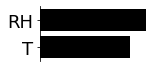

logistic_regression rem_percent


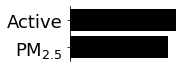

logistic_regression tst


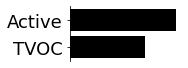

logistic_regression sol


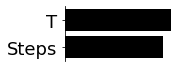

logistic_regression naw


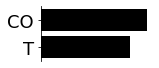

logistic_regression restful


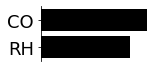

logistic_regression tst


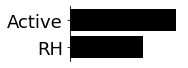

random_forest se


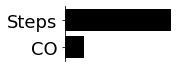

random_forest rem_percent


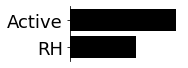

random_forest tst


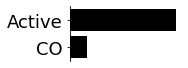

random_forest sol


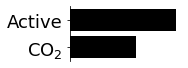

random_forest naw


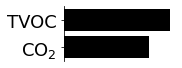

random_forest restful


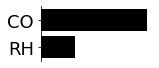

random_forest tst


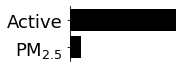

In [56]:
fis_important = fis.loc[["logistic_regression","random_forest"],:]
for row in range(len(fis_important)):
    print(fis_important.index[row],fis_important["metric"][row])
    best = fis_important.iloc[:,:-1].iloc[row,:].sort_values(ascending=False)
    new_ix = []
    for ix in best.index.values:
        new_ix.append(ix.split("_")[0])
    best.index = new_ix
    best.rename({"rh":"RH","temperature":"T","active":"Active","tvoc":"TVOC","steps":"Steps","pm2p5":"PM$_{2.5}$","co":"CO","co2":"CO$_2$"},inplace=True)
    best_normal = (best - min(best))/(max(best) - min(best))
    _, ax = plt.subplots(figsize=(2,1))
    labels = list(best_normal.index[:2])
    labels.reverse()
    vals = list(best_normal[:2])
    vals.reverse()
    ax.barh(y=labels,width=vals,color="black")
    ax.set_yticklabels(labels,fontsize=18)
    for loc in ["top","right","bottom"]:
        ax.spines[loc].set_visible(False)
    ax.get_xaxis().set_visible(False)
    if row in [2,9]:
        annot = "_fb"
    else:
        annot= ""
    plt.savefig(f"../reports/conferences/BuildSys_2021/feature_importance-{fis_important.index[row]}-{fis_important['metric'][row]}{annot}.pdf",bbox_inches="tight")
    plt.show()
    plt.close()

In [57]:
d = {}
for row in range(len(fis)):
    #print(fis.iloc[row,-1].upper(), fis.index[row].replace("_"," ").title())
    best = fis.iloc[:,:-1].iloc[row,:].sort_values(ascending=False)
    best_normal = (best - min(best))/(max(best) - min(best))
    #print(best.index[:3].values,"\n")
    best_vars = [var.split("_")[0].upper() for var in best_normal.index[:3].values]
    best_scores = [f"-{round(score,3)}=" for score in best_normal[:3].values]
    vars_and_score = [a for b in zip(best_vars, best_scores) for a in b]
    d[fis.iloc[row,-1].upper(), fis.index[row].replace("_"," ").title()] = vars_and_score
pd.DataFrame.from_dict(d,orient="index")

,0,1,2,3,4,5
"(SE, Logistic Regression)",RH,-1.0=,TEMPERATURE,-0.845=,ACTIVE,-0.603=
"(SE, Knn)",CO2,-nan=,CO,-nan=,TVOC,-nan=
"(SE, Random Forest)",STEPS,-1.0=,CO,-0.181=,RH,-0.144=
"(REM_PERCENT, Logistic Regression)",ACTIVE,-1.0=,PM2P5,-0.924=,RH,-0.823=
"(REM_PERCENT, Knn)",CO2,-nan=,CO,-nan=,TVOC,-nan=
"(REM_PERCENT, Random Forest)",ACTIVE,-1.0=,RH,-0.621=,PM2P5,-0.581=
"(TST, Logistic Regression)",ACTIVE,-1.0=,RH,-0.688=,CO2,-0.485=
"(TST, Knn)",CO2,-nan=,CO,-nan=,TVOC,-nan=
"(TST, Random Forest)",ACTIVE,-1.0=,PM2P5,-0.105=,RH,-0.079=
"(SOL, Logistic Regression)",TEMPERATURE,-1.0=,STEPS,-0.925=,CO,-0.845=


## Optimizing Models
Looking at different components of:
* classifiers
* validation
* hyperparameters

### Aggregate
All the participants' data considered and stratified according to the number of observations.

Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.124879
		Best Score:	0.7836805555555555
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Gradientboost
		Elapsed Time:	 0:00:10.099867
		Best Score:	0.7962301587301587
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:01.670955
		Best Score:	0.7711805555555555
		Best Params:	{'metric': 'matching', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Gradientboost
		Score:	0.796
		Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
GRADIENTBOOST
Training...
Predicting...
	Cross Validation Scores:
		0.635
		0.635
		0.635
		0.635
		0.63
	Average:	0.634
	Model Score: 0.719
Evaluating...


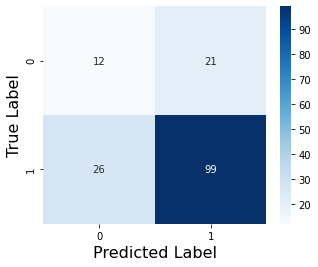

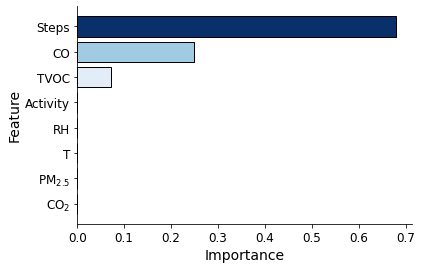

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.632
		0.708
		0.632
		0.635
		0.726
	Average:	0.667
	Model Score: 0.712
Evaluating...


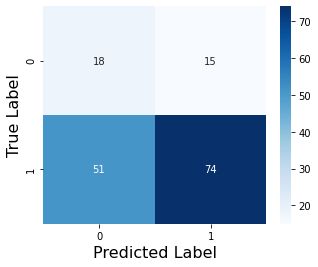

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.666
		0.688
		0.708
		0.744
		0.627
	Average:	0.687
	Model Score: 0.624
Evaluating...


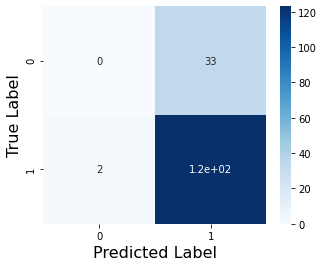

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.200191
		Best Score:	0.6740079365079366
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Gradientboost
		Elapsed Time:	 0:00:10.930820
		Best Score:	0.6740079365079366
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:01.808175
		Best Score:	0.6426587301587301
		Best Params:	{'metric': 'matching', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.674
		Params:	{'fit_intercept': True, 'solver': 'liblinear'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.451
		0.451
		0.451
		0.451
		0.466
	Average:	0.454
	Model Score: 0.572
Evaluating...


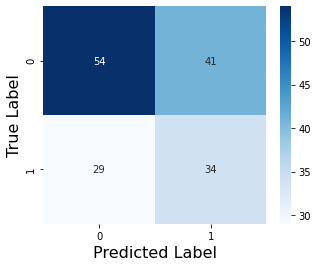

'LogisticRegression' object has no attribute 'feature_importances_'
GRADIENTBOOST
Training...
Predicting...
	Cross Validation Scores:
		0.451
		0.451
		0.451
		0.451
		0.466
	Average:	0.454
	Model Score: 0.496
Evaluating...


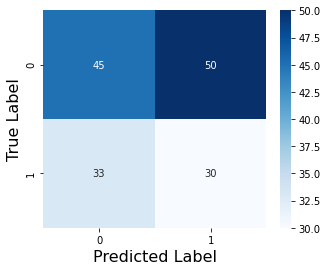

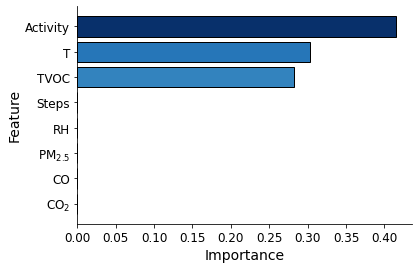

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.561
		0.595
		0.718
		0.603
	Average:	0.608
	Model Score: 0.565
Evaluating...


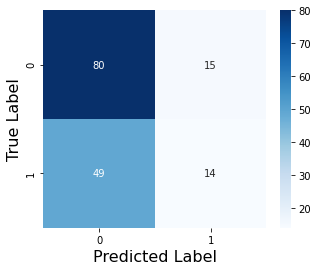

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.105649
		Best Score:	0.5926091269841269
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Gradientboost
		Elapsed Time:	 0:00:12.464415
		Best Score:	0.5737103174603175
		Best Params:	{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:02.151998
		Best Score:	0.5550595238095238
		Best Params:	{'metric': 'jaccard', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Logistic Regression
		Score:	0.593
		Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.653
		0.58
		0.548
		0.635
	Average:	0.596
	Model Score: 0.5
Evaluating...


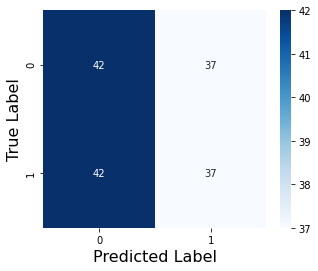

'LogisticRegression' object has no attribute 'feature_importances_'
GRADIENTBOOST
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.597
		0.585
		0.549
		0.59
	Average:	0.577
	Model Score: 0.513
Evaluating...


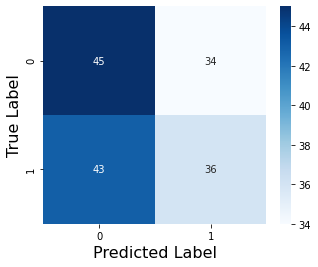

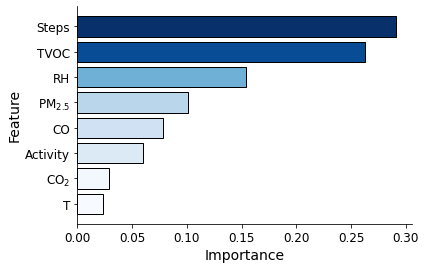

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.562
		0.516
		0.484
		0.597
		0.629
	Average:	0.558
	Model Score: 0.507
Evaluating...


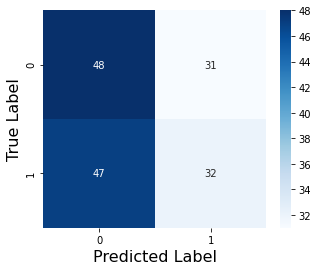

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.145798
		Best Score:	0.5454365079365079
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Gradientboost
		Elapsed Time:	 0:00:11.725541
		Best Score:	0.5830853174603174
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:02.072014
		Best Score:	0.5549603174603175
		Best Params:	{'metric': 'jaccard', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Gradientboost
		Score:	0.583
		Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
GRADIENTBOOST
Training...
Predicting...
	Cross Validation Scores:
		0.353
		0.334
		0.334
		0.334
		0.345
	Average:	0.34
	Model Score: 0.59
Evaluating...


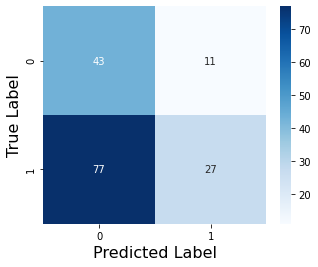

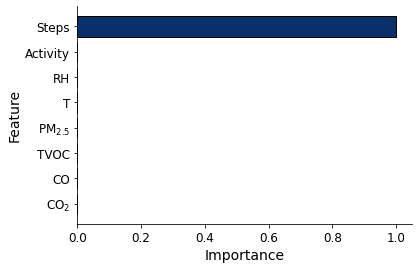

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.557
		0.566
		0.517
		0.523
		0.566
	Average:	0.546
	Model Score: 0.471
Evaluating...


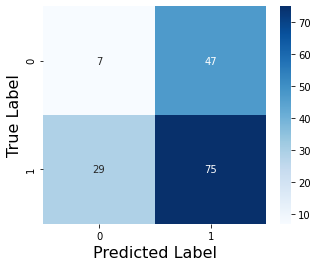

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.77
		0.552
		0.37
		0.408
		0.475
	Average:	0.515
	Model Score: 0.645
Evaluating...


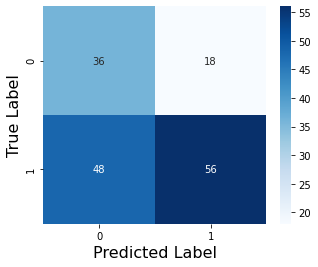

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.134524
		Best Score:	0.6456845238095238
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Gradientboost
		Elapsed Time:	 0:00:13.553241
		Best Score:	0.6520337301587301
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:02.493028
		Best Score:	0.6332837301587302
		Best Params:	{'metric': 'jaccard', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Gradientboost
		Score:	0.652
		Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
GRADIENTBOOST
Training...
Predicting...
	Cross Validation Scores:
		0.41
		0.431
		0.431
		0.431
		0.424
	Average:	0.425
	Model Score: 0.495
Evaluating...


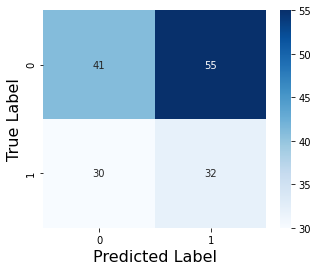

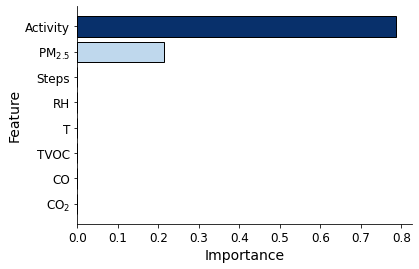

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.407
		0.431
		0.431
		0.67
		0.416
	Average:	0.471
	Model Score: 0.505
Evaluating...


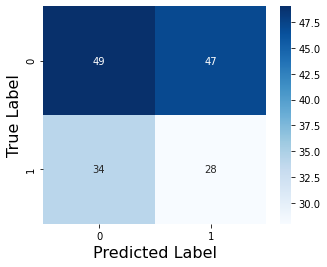

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.64
		0.691
		0.553
		0.508
		0.632
	Average:	0.605
	Model Score: 0.531
Evaluating...


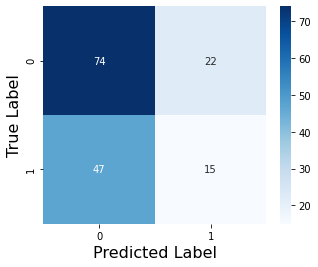

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.150886
		Best Score:	0.6397727272727273
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Gradientboost
		Elapsed Time:	 0:00:10.568336
		Best Score:	0.6585227272727272
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:01.929564
		Best Score:	0.6270833333333333
		Best Params:	{'metric': 'jaccard', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Gradientboost
		Score:	0.659
		Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
GRADIENTBOOST
Training...
Predicting...
	Cross Validation Scores:
		0.405
		0.431
		0.431
		0.788
		0.431
	Average:	0.497
	Model Score: 0.656
Evaluating...


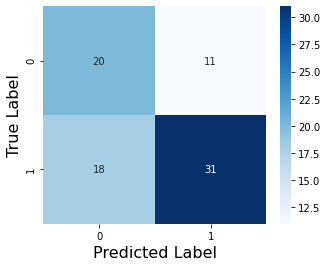

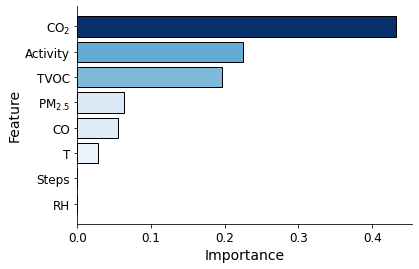

LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.405
		0.423
		0.609
		0.431
		0.423
	Average:	0.458
	Model Score: 0.687
Evaluating...


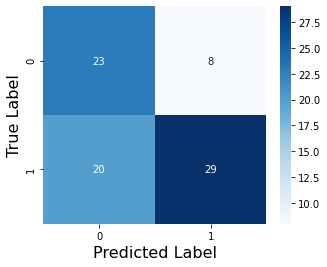

'LogisticRegression' object has no attribute 'feature_importances_'
K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.65
		0.777
		0.566
		0.518
		0.496
	Average:	0.602
	Model Score: 0.636
Evaluating...


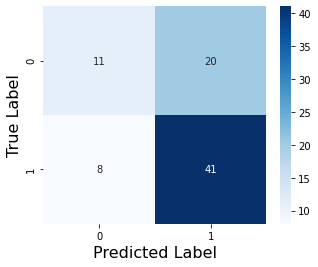

'KNeighborsClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (sol)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.109984
		Best Score:	0.5399621212121212
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Gradientboost
		Elapsed Time:	 0:00:10.617477
		Best Score:	0.5839015151515151
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:01.854667
		Best Score:	0.5587121212121212
		Best Params:	{'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Gradientboost
		Score:	0.584
		Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
GRADIENTBOOST
Training...
Predicting...
	Cross Validation Scores:
		0.57
		0.585
		0.591
		0.656
		0.496
	Average:	0.58
	Model Score: 0.503
Evaluating...


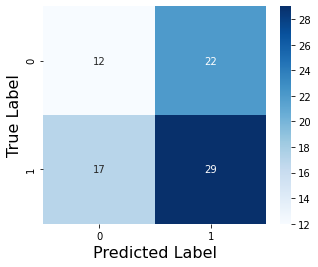

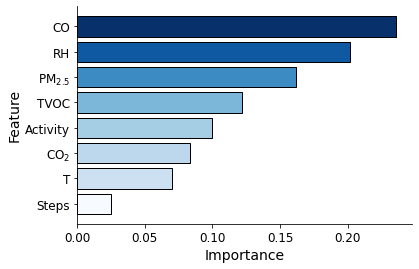

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.604
		0.551
		0.591
		0.593
		0.423
	Average:	0.552
	Model Score: 0.604
Evaluating...


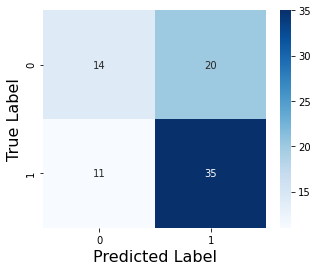

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.603
		0.62
		0.556
		0.538
		0.368
	Average:	0.537
	Model Score: 0.465
Evaluating...


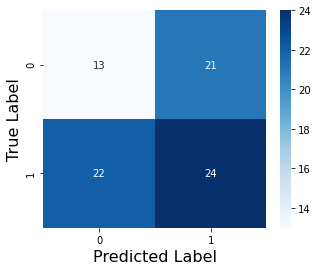

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (naw)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.110104
		Best Score:	0.459469696969697
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Gradientboost
		Elapsed Time:	 0:00:10.407011
		Best Score:	0.6337121212121212
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:01.892318
		Best Score:	0.5905303030303031
		Best Params:	{'metric': 'matching', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Gradientboost
		Score:	0.634
		Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
GRADIENTBOOST
Training...
Predicting...
	Cross Validation Scores:
		0.607
		0.597
		0.594
		0.688
		0.69
	Average:	0.635
	Model Score: 0.645
Evaluating...


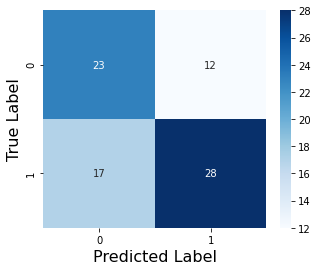

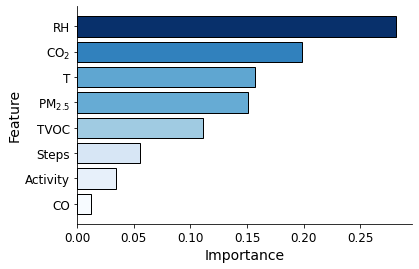

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.523
		0.5
		0.594
		0.727
		0.627
	Average:	0.594
	Model Score: 0.536
Evaluating...


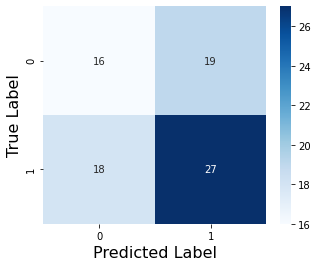

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.488
		0.438
		0.469
		0.468
		0.437
	Average:	0.46
	Model Score: 0.592
Evaluating...


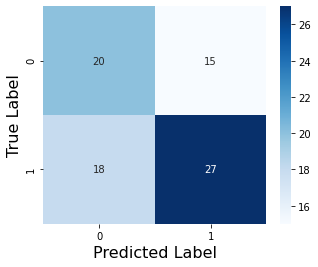

'LogisticRegression' object has no attribute 'feature_importances_'
Getting Features and Target (restful)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.113240
		Best Score:	0.8261363636363637
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Gradientboost
		Elapsed Time:	 0:00:09.719644
		Best Score:	0.8323863636363636
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:02.302804
		Best Score:	0.8323863636363636
		Best Params:	{'metric': 'euclidean', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Best Scoring Model:
		Model:	Gradientboost
		Score:	0.832
		Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
GRADIENTBOOST
Training...
Predicting...
	Cross Validation Scores:
		0.669
		0.712
		0.712
		0.712
		0.66
	Average:	0.693
	Model Score: 0.68
Evaluating...


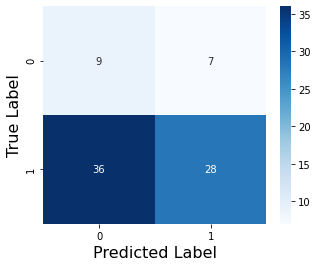

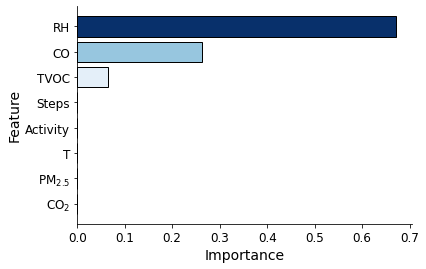

K-NEAREST NEIGHBOR
Training...
Predicting...
	Cross Validation Scores:
		0.669
		0.712
		0.712
		0.712
		0.66
	Average:	0.693
	Model Score: 0.715
Evaluating...


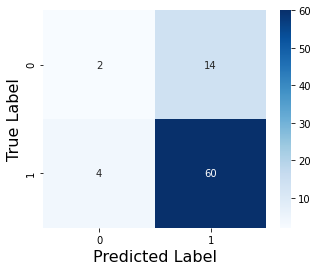

'KNeighborsClassifier' object has no attribute 'feature_importances_'
LOGISTIC REGRESSION
Training...
Predicting...
	Cross Validation Scores:
		0.669
		0.712
		0.708
		0.712
		0.66
	Average:	0.692
	Model Score: 0.773
Evaluating...


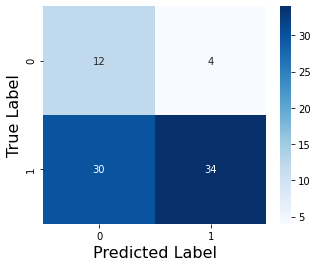

'LogisticRegression' object has no attribute 'feature_importances_'


In [58]:
agg_pred = ieq_and_sq_prediction()
agg_res = {"target":[],"best_performing_model":[],"model":[],"model_score":[],"biased_score":[],"hyper_parameters":[],"sensitive_parameter1":[],"sensitive_parameter2":[]}
for target_set, targets in zip([fbsq,srsq],[["se","tst","light_percent","deep_percent","rem_percent"],["tst","sol","naw","restful"]]):
    for target in targets:
        agg_pred.run(ieq_activity_and_fb_select,target_set,target)
        for i in range(len(agg_pred.results)):
            agg_res["target"].append(target)
            agg_res["best_performing_model"].append(agg_pred.results.iloc[0,0])
            agg_res["model"].append(agg_pred.results.iloc[i,0])
            agg_res["model_score"].append(agg_pred.results.iloc[i,1])
            bs = sum(agg_pred.targets.values)/len(agg_pred.targets)
            agg_res["biased_score"].append(bs[0] if bs[0] > 0.5 else 1-bs[0])
            agg_res["hyper_parameters"].append(agg_pred.results.iloc[i,2])
            try:
                agg_res["sensitive_parameter1"].append(agg_pred.feature_importance.sort_values("importance",ascending=False).iloc[0,0])
                agg_res["sensitive_parameter2"].append(agg_pred.feature_importance.sort_values("importance",ascending=False).iloc[1,0])
            except KeyError:
                agg_res["sensitive_parameter1"].append(np.nan)
                agg_res["sensitive_parameter2"].append(np.nan)

In [ ]:
agg_res_df = pd.DataFrame(agg_res)
#agg_res_df.to_csv("/Users/hagenfritz/Desktop/sleep_prediction-aggregate-results.csv")
agg_res_df

### Per Participant
Now we try another model where we considering only 1 participant, train on a subset of their data and see about predicting their sleep quality.

We first have to identify applicable participants. After an initial inspection, there seems to be a good cutoff of about **30 nights** that would give us a minimum of 20 nights for training and 10 for testing.

#### Self-Report

In [ ]:
ieq_and_srsq = ieq_and_activity.merge(right=srsq,on=["beiwe","redcap","beacon","end_date"])
n_nights_sr = ieq_and_srsq[["start_time","beiwe"]].groupby("beiwe").count().sort_values("start_time",ascending=False)
n_nights_gt20 = n_nights_sr[n_nights_sr["start_time"] >= 20]
n_nights_gt20

<div class="alert alert-block alert-warning">

There really aren't that many available nights of data. Perhaps we can use the participants with at least 20 nights of data?
    
</div>

In [ ]:
ieq_activity_and_sr_gt20 = ieq_and_activity[ieq_and_activity["beiwe"].isin(n_nights_gt20.index)]

#### Classification
Now that we have the 8 participants identified, we can run the classification models.

In [ ]:
ind_pred = ieq_and_sq_prediction()
ind_res = {"beiwe":[],"n":[],"target":[],"best_performing_model":[],"model_score":[],"biased_score":[],"sensitive_parameter1":[],"sensitive_parameter2":[]}
for dataset, target_set, targets in zip([ieq_activity_and_fb_gt30,ieq_activity_and_sr_gt20],[fbsq,srsq],[["se","tst","light_percent","deep_percent","rem_percent"],["tst","sol","naw","restful"]]):
    for pt in dataset["beiwe"].unique():
        print(pt.upper())
        fts = dataset[dataset["beiwe"] == pt]
        tgts = target_set[target_set["beiwe"] == pt]
        for target in targets:
            if len(tgts[f"{target}_binary"].unique()) > 1:
                try:
                    ind_pred.run(fts,tgts,target)
                    # adding results
                    ind_res["beiwe"].append(pt)
                    ind_res["n"].append(len(ind_pred.features))
                    ind_res["target"].append(target)
                    ind_res["best_performing_model"].append(ind_pred.results.iloc[0,0])
                    ind_res["model_score"].append(ind_pred.results.iloc[0,1])
                    bs = sum(ind_pred.targets.values)/len(ind_pred.targets)
                    ind_res["biased_score"].append(bs[0] if bs[0] > 0.5 else 1-bs[0])
                    try:
                        ind_res["sensitive_parameter1"].append(ind_pred.feature_importance.sort_values("importance",ascending=False).iloc[0,0])
                        ind_res["sensitive_parameter2"].append(ind_pred.feature_importance.sort_values("importance",ascending=False).iloc[1,0])
                    except KeyError:
                        ind_res["sensitive_parameter1"].append(np.nan)
                        ind_res["sensitive_parameter2"].append(np.nan)
                except ValueError as e:
                    print(e)
            else:
                print("Only 1 unique value for", target.replace("_"," "))

In [ ]:
ind_res_df = pd.DataFrame(ind_res)
ind_res_df.to_csv("/Users/hagenfritz/Desktop/sleep_prediction-individual-results.csv")

### Predicting other Participant Sleep Quality
We can also create a scheme where we predict the sleep quality of a few participants by training on a larger subset of the participants. 

We have two tools for model selection:
1. GroupKFold: Here we specify a certain number of splits to be made and a leave a subset of participants out of the training set to use as the test set. 
2. LeaveOneGroupOut: This cross-validation goes as far as to include all but one participant in the training set. Then we try to predict the sleep quality of that left-out individual.

In [ ]:
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut

group_pred = ieq_and_sq_prediction()

gkf = GroupKFold(n_splits=4)#len(test.features["count"].unique()))
res_group = {"split":[],"n_train":[],"n_test":[],"target":[],"best_performing_model":[],"model_score":[],"biased_score":[],"sensitive_parameter1":[],"sensitive_parameter2":[]}
for target_set, targets in zip([fbsq,srsq],[["se","tst","light_percent","deep_percent","rem_percent"],["tst","sol","naw","restful"]]):
    for target in targets: 
        group_pred.get_features_and_targets(ieq_and_activity,target_set,target)
        i = 1
        for train, test in gkf.split(group_pred.features, group_pred.targets, groups=group_pred.features["count"]):
            print("SPLIT", i)
            print(f"\tTrain:\t{len(train)}\n\tTest:\t{len(test)}\n")
            group_pred.set_test_and_train(group_pred.features.iloc[train,:],group_pred.features.iloc[test,:],group_pred.targets.iloc[train,:],group_pred.targets.iloc[test,:])
            group_pred.optimize_models()
            # saves the best model, trains on the best model, predicts with the model, and plots the confusion matrix
            for model_number in range(len(group_pred.results)):
                print(group_pred.results.iloc[model_number,0].replace("_"," ").upper())
                group_pred.model = group_pred.classifier_model_params[group_pred.results.iloc[model_number,:]["model"]]["model"].set_params(**group_pred.results.iloc[model_number,:]["best_params"])
                group_pred.train_model(group_pred.model)
                group_pred.predict()
                group_pred.plot_confusion_matrix()
                group_pred.set_feature_importance(plot=True)

            res_group["split"].append(i)
            res_group["n_train"].append(len(train))
            res_group["n_test"].append(len(test))
            res_group["target"].append(target)
            res_group["best_performing_model"].append(group_pred.results.iloc[0,0])
            res_group["model_score"].append(group_pred.results.iloc[0,1])
            bs = sum(group_pred.targets.values)/len(group_pred.targets)
            res_group["biased_score"].append(bs[0] if bs[0] > 0.5 else 1-bs[0])
            try:
                res_group["sensitive_parameter1"].append(group_pred.feature_importance.sort_values("importance",ascending=False).iloc[0,0])
                res_group["sensitive_parameter2"].append(group_pred.feature_importance.sort_values("importance",ascending=False).iloc[1,0])
            except KeyError:
                res_group["sensitive_parameter1"].append(np.nan)
                res_group["sensitive_parameter2"].append(np.nan)

            i += 1

In [ ]:
group_res_df = pd.DataFrame(res_group)
group_res_df.to_csv("/Users/hagenfritz/Desktop/sleep_prediction-groups-results.csv")

## Summary of Prediction Models
Now we look more in-depth at the different prediction models.

In [ ]:
def plot_hist(var):
    """plots histogram of variable"""
    fig, axes = plt.subplots(1,3,figsize=(21,4))
    for data, title, ax in zip([agg_res_df,ind_res_df,group_res_df],["aggregated","per participant","grouped"],axes.flat):
        data.sort_values(var,inplace=True)
        sns.histplot(x=var,data=data, shrink=0.8, stat="probability", color="cornflowerblue", discrete=True, linewidth=2, ax=ax)
        # y-axis
        ax.set_ylim([0,1])
        # remainder
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        ax.set_title(title.title())
        
        ax.tick_params("x",rotation=-15,labelsize=10)
    plt.show()
    plt.close()

### Hyperparameter Tuning
Included in the results are the hyperparameters that produced the greatest score per model. We can summarize those here.

In [ ]:
from collections import defaultdict
res = agg_res_df
for m in res["model"].unique():
    print(m)
    dd = defaultdict(list)
    res_by_model = res[res["model"] == m]
    for d in res_by_model["hyper_parameters"]: # you can list as many input dicts as you want here
        for key, value in d.items():
            dd[key].append(value)
    print(pd.DataFrame(dd))

The following hyperparameters should be used:
* **Logistic Regression**: (fit_intercpt=True,solver="lbfgs")
* **Random Forest**: (max_depth=2,min_samples_leaf=1,min_samples_split=2,n_esimators=10)
* **Naive Bayes**: (alpha=0.0)
* **KNN**: (n_neighbors=7,p=1,weights=uniform)

### Best Performing Model
We take a look at the model that tended to produce the best score.

In [ ]:
plot_hist("best_performing_model")

#### Winner
In all three cases, the **Random Forest Model** produced the highest scores, on average, compared to the other three.

#### Loser(s)
* **KNN** only showed up a few times in the per participant procedure but not in either of the other two procedures
* **Naive-Bayes** showed the opposite behavior: showing up in only the first and third procedures despite being better equiped to handle smaller datasets which was the case for the per participant procedure.

### Variable Contribution
We can also look at which variable tended to be the most useful in the model development.

In [ ]:
plot_hist("sensitive_parameter1")

In [ ]:
plot_hist("sensitive_parameter2")

#### Winner
**TVOCs** are the only variable that shows a consistent effect on the model development whether that be the first or second most influential parameter. 

#### Per Participant
* **PM2.5** seems to affect this procedure more so than the either two

#### Grouped
* **Activity** seems to have a somewhat large effect especially when considering the **steps** variable in conjunction

### Comparing Scores
We can look at the model scores compared to the "biased" score to see how well our models performed.

In [ ]:
def plot_bar():
    """plots histogram of variable"""
    fig, axes = plt.subplots(1,3,figsize=(21,4))
    for data, title, ax in zip([agg_res_df,ind_res_df,group_res_df],["aggregated","per participant","grouped"],axes.flat):
        df_to_plot = pd.melt(data,id_vars=["target"],value_vars=["model_score","biased_score"])
        sns.barplot(x="target",y="value",hue="variable",data=df_to_plot, hue_order=["biased_score","model_score"],palette=["gray","seagreen"], edgecolor="black",linewidth=2, ax=ax)
        # y-axis
        ax.set_ylim([0,1])
        ax.set_ylabel("Score")
        # remainder
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        ax.set_title(title.title())
        ax.legend(loc="lower left",framealpha=1)
        
        ax.tick_params("x",rotation=-15,labelsize=10)
    plt.show()
    plt.close()

In [ ]:
plot_bar()

#### Aggregated
In all cases but `restful` and `rem_percent`, the model out-performed the biased score most noteably for:
* `naw`
* `light_percent`

#### Per Participant
On average, the models were able to out-perform the biased score except in the case of `light_percent`, most notably:
* `rem_percent`
* `restful`

#### Grouped
The worst-performing procedure where the majority of the scores are similar between the biased and model performance. Only the estimation of `naw` seems to be signficiantly different.

### Aggregate: Deep Dive

In [ ]:
agg_res_df["dScore"] = agg_res_df["model_score"] - agg_res_df["biased_score"]
agg_res_df.sort_values("dScore",ascending=False)

Using this procedure, we are able to see noticeable differences in the scores between `naw` and `tst` targets.

### Per Participant: Deep Dive

In [ ]:
ind_res_df["dScore"] = ind_res_df["model_score"] - ind_res_df["biased_score"]
ind_res_df.groupby("target").mean().sort_values("dScore", ascending=False)

By looking at the mean difference in the scores across the participants sleep targets, we can predict `rem_percent` and `restful` more accurately than a biased score. 

In [ ]:
high_scoring_ind = ind_res_df.sort_values("dScore",ascending=False)[ind_res_df["dScore"] > 0.05]
high_scoring_ind

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(x="sensitive_parameter2",data=high_scoring_ind, shrink=0.8, stat="probability", color="cornflowerblue", discrete=True, linewidth=2, ax=ax)
# y-axis
ax.set_ylim([0,1])
# remainder
for loc in ["top","right"]:
    ax.spines[loc].set_visible(False)

ax.tick_params("x",rotation=-15,labelsize=10)
plt.show()
plt.close()

By looking at the top scoring models, we can see they are primarily:
* random forest (and even those that are logistic regression might have scores equal to random forest but were selected since they came first)
* `rem_percent`
* sensitive to `pm2p5`, `temperature`, and `tvoc`

### Grouped: Deep Dive

In [ ]:
group_res_df["dScore"] = group_res_df["model_score"] - group_res_df["biased_score"]
group_res_df.sort_values(["split","dScore"],ascending=False)
#group_res_df.groupby(["split","target"]).mean()

There seem to be significant differences in the performance of the models based on the splits.

Leave One Group Out

Stratified K-Fold

In [ ]:
dd